# Parse IIS Logs and plot charts

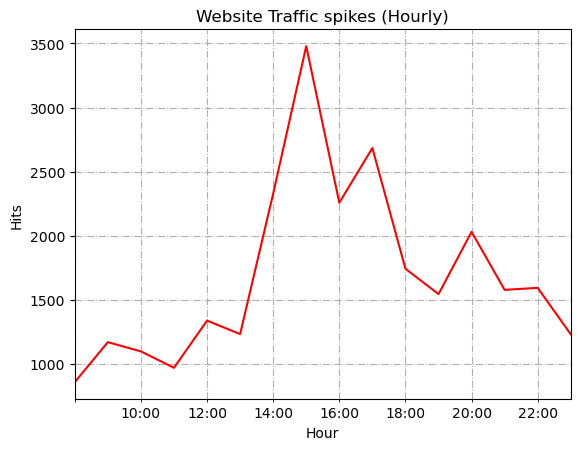

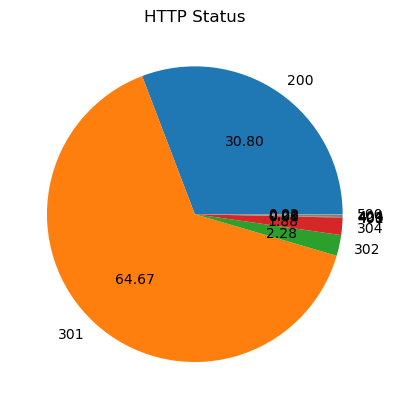

In [36]:
import fileinput
import pandas as pd
import os
import datetime as dt
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import numpy as np

def parse_log(filepath):
    basename = os.path.basename(filepath)

    header = ['date', 'time', 's-ip', 'cs-method', 
                        'cs-uri-stem', 'cs-uri-query', 's-port', 
                        'cs-username', 'c-ip', 'cs(User-Agent)', 
                        'sc-status', 'sc-substatus', 'sc-win32-status', 
                        'sc-bytes', 'cs-bytes', 'time-taken']

    list_dict = []

    for line in fileinput.input(filepath, encoding='utf8'):
        if not line.startswith('#'):
            fields = line.split()
            d = dict(zip(header, fields))
            list_dict.append(d)
        

    df = pd.DataFrame.from_dict(list_dict)
    # Convert from UTC to local time
    df['date_time'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str)) + get_local_time_offset()
    df.drop(['date', 'time'], axis=1, inplace=True)

    return df

def get_local_time_offset():
        now_ts = time.time()
        offset = dt.datetime.fromtimestamp(now_ts) - dt.datetime.utcfromtimestamp(now_ts)
        return offset

def find_records(df, start, end):
    df2 = df[(df['date_time'] >= start) & (df['date_time'] <= end) & (df['sc-substatus'] == '200')]
    return df2

def log_grouper(df, interval='60Min'):
    df2 = df.groupby(pd.Grouper(freq=interval, key='date_time'))['date_time'].count()
    return df2

def plot_http_status(df):
    df2 = df.groupby(['sc-substatus'])['sc-substatus'].count()
    df2.plot.pie(ylabel='', autopct='%.2f')
    plt.title('HTTP Status')
    plt.show()
    
def plot_http_traffic(df, start, end, color):
    df2 = find_records(df, start, end)
    df2 = log_grouper(df2)

    df2.plot(title='Website Traffic spikes (Hourly)', xlabel='Hour', ylabel='Hits', grid=True, color=color)
    ax = plt.gca()
    #ax.xaxis.set_major_locator(md.MinuteLocator(interval=30))
        

    ax.grid(True, linestyle='-.', which='both', axis='both')
    xloc=md.MinuteLocator(byminute = [0, 30, 60])
    ax.xaxis.set_major_locator(xloc)
    ax.tick_params(axis='x', which='major', bottom='on', length=5, width=1, labelsize=6)
    plt.show()



start = dt.datetime(2023, 8, 31, 0, 0, 0)
end = dt.datetime(2023, 8, 31, 23, 59, 59)
df = parse_log(f'./u_ex230831.log')
plot_http_traffic(df, start, end, 'red')

plot_http_status(df)